# CO2 source: WDCGG 129 stations, 1968-2017
# CO2 analysis method: NOAA

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import ccg_filter
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

font = {'weight' : 'bold', 'size' : 14}
matplotlib.rc('font', **font)

# Define functions 

In [2]:
def decimalDate_ymd (year, month, day=15):
    """ Convert a date to a fractional year. """
    pd_date = pd.to_datetime(year*10000 + month*100 + day, format='%Y%m%d')
    
    return pd_date.dt.year + pd_date.dt.dayofyear / [366 if x else 365 for x in pd_date.dt.is_leap_year]

In [3]:
def decimalDate_datetime (datetime):
    """ Convert a date to a fractional year. """
    
    return datetime.dt.year + datetime.dt.dayofyear / [366 if x else 365 for x in datetime.dt.is_leap_year]

In [4]:
def grid_area (resolution=0.5):
    """Calculate the area of each grid cell for a user-provided
    grid cell resolution. Area is in square meters, but resolution
    is given in decimal degrees."""
    # Calculations needs to be in radians
    lats = np.deg2rad(np.arange(-90,90+resolution, resolution))
    r_sq = 6371000**2
    n_lats = int(360./resolution) 
    area = r_sq*np.ones(n_lats)[:, None]*np.deg2rad(resolution)*(
                np.sin(lats[1:]) - np.sin(lats[:-1]))
    return area.T

In [23]:
def zonal_mean(df, zonal_deg, dat_cols, lat_col = "lat"):
    """ Latitude zonal average """
    
    lat_range = range(-90,90,zonal_deg)
    df_zonal_raw = pd.DataFrame()
    
    for i in lat_range:
        lat_id = (i < df[lat_col]) & (df[lat_col] <= i+zonal_deg)
        temp_raw = df.loc[lat_id,:]
        df_zonal_raw = pd.concat([df_zonal_raw,  pd.DataFrame(temp_raw[dat_cols].mean()).T] )

    df_zonal_raw["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
    cols_new = df_zonal_raw.columns.to_list()
    cols_new = cols_new[-1:] + cols_new[:-1]
    df_zonal_raw = df_zonal_raw.loc[:,cols_new]
    df_zonal_raw = df_zonal_raw.iloc[::-1] 
    df_zonal_raw = df_zonal_raw.set_index(["lat"])
    return df_zonal_raw

In [5]:
IN_PATH = "D:\\MyData\\jupter\\icos\\wdcgg_obs\\"
OUT_PATH = "D:\\MyData\\jupter\\icos\\wdcgg_obs\\"

# Organize raw and calculated co2 from 129 stations into one dataframe, respectively

In [6]:
# read metadata and list the files/output from fit_filter_noaa.ipynb
df_meta = pd.read_csv(IN_PATH+"df_meta_wdcgg.csv", encoding = "ISO-8859-1")
csvfiles = listdir(IN_PATH+"output\\")
df_meta["monthes"] = 0
df_meta["flag"] = 0

# orginaze full monthly time series from 1968 to 2017
df_fullperiod = pd.DataFrame()
df_fullperiod["date"] = pd.date_range(start='1968-01-01', end='2017-12-31', freq="M")
df_fullperiod.date = df_fullperiod.date.apply(lambda dt: dt.replace(day=15))
df_fullperiod['decimalyear'] = decimalDate_ymd( df_fullperiod.date.dt.year,  df_fullperiod.date.dt.month, 15)

# combine the raw and calculated co2 from 185 csv files into a single csv file with lon and lat
df_co2_raw = pd.DataFrame()
df_co2_cal = pd.DataFrame()
df_co2rate_cal = pd.DataFrame()
    
for i in range(df_meta.shape[0]):
#     i = 0
    # using csv file name to find right lon and lat from metadata (df_meta_selected_ctracker_update.csv)
    pre_filename = df_meta.FILENAME[i].split(".")[0]
    matching = [s for s in csvfiles if pre_filename in s]
    
    if len(matching) != 1:
        print(f"Warming: the file {pre_filename} is excluded in this analysis, due to less data")
        continue
    df_meta.at[i,"flag"]= 1
    
    # read csv data, and fill in full period (2000-2017)
    dat = pd.read_csv(IN_PATH+"output\\"+ matching[0])
    dat.date = pd.to_datetime(dat.date)
    df_merge = pd.merge(df_fullperiod,dat, how="left", on="date")
    
    df_meta.at[i,"monthes"]= dat.shape[0]
    # combine sitecode, lon, lat, filename, and 216 months co2 as one row, and concatanate them into dataframe
    record_raw = pd.concat([df_meta.iloc[i,[2,6,5,1]],df_merge.co2])
    record_cal = pd.concat([df_meta.iloc[i,[2,6,5,1]],df_merge.polypart + df_merge.harmpart + df_merge.resid_smooth])
    df_co2_raw = pd.concat([df_co2_raw, record_raw], axis=1)
    df_co2_cal = pd.concat([df_co2_cal, record_cal], axis=1)
    
    record_cal = pd.concat([df_meta.iloc[i,[2,6,5,1]],df_merge.growth_rate])
    df_co2rate_cal = pd.concat([df_co2rate_cal, record_cal], axis=1)
    
print(f"Remain {df_co2_cal.shape[1]} stations data for analysis")

# save files
df_co2_raw = df_co2_raw.T.reset_index(drop=True)       
df_co2_cal = df_co2_cal.T.reset_index(drop=True)
df_co2rate_cal = df_co2rate_cal.T.reset_index(drop=True)

df_co2_raw.columns = ['sitename', 'lon', 'lat', 'file'] + [d.strftime('%Y-%m-%d') for d in df_fullperiod["date"]]
df_co2_cal.columns = ['sitename', 'lon', 'lat', 'file'] + [d.strftime('%Y-%m-%d') for d in df_fullperiod["date"]]
df_co2rate_cal.columns = ['sitename', 'lon', 'lat', 'file'] + [d.strftime('%Y-%m-%d') for d in df_fullperiod["date"]]

df_co2_raw.to_csv(OUT_PATH + "df_co2_raw_wdcgg_obs_noaa.csv", header=True,index=False, na_rep= "NaN")
df_co2_cal.to_csv(OUT_PATH + "df_co2_cal_wdcgg_obs_noaa.csv", header=True,index=False, na_rep= "NaN")
df_co2rate_cal.to_csv(OUT_PATH + "df_co2rate_cal_wdcgg_obs_noaa.csv", header=True,index=False, na_rep= "NaN")

df_meta.to_csv(OUT_PATH +"df_meta_wdcgg_update.csv", header=True,index=False, na_rep= "NaN")

Remain 129 stations data for analysis


# Calculate zonal and global co2 average over each 30 degree latitudinal band

In [98]:
df_co2_raw = pd.read_csv(IN_PATH + "df_co2_raw_wdcgg_obs_noaa.csv")
df_co2_cal = pd.read_csv(IN_PATH + "df_co2_cal_wdcgg_obs_noaa.csv")

zonal_deg = 30

df_zonal_raw = zonal_mean(df_co2_raw, zonal_deg, df_co2_raw.columns[4:], "lat")
df_zonal_cal = zonal_mean(df_co2_cal, zonal_deg, df_co2_cal.columns[4:], "lat")

nanindex_raw  = df_zonal_raw.apply(np.isnan)
nanindex_cal  = df_zonal_cal.apply(np.isnan)

# area weight
df_area = pd.DataFrame(grid_area(0.5))
area_lat = df_area.iloc[:,0]
area_zonal = area_lat.groupby(np.arange(len(area_lat))//(zonal_deg/0.5)).sum()

global_weight = area_zonal/area_zonal.sum()
NH_weight = area_zonal[:len(area_zonal)/2-1] /(area_zonal.sum()/2)
SH_weight = area_zonal[len(area_zonal)/2:] /(area_zonal.sum()/2)

global_weight = global_weight.set_axis(df_zonal_raw.index)
NH_weight = NH_weight.set_axis(df_zonal_raw.index[:3])
SH_weight = SH_weight.set_axis(df_zonal_raw.index[3:])

# replicate weight column wise
df_global_weight= pd.concat([global_weight]*df_zonal_raw.shape[1], ignore_index=True, axis=1)
df_NH_weight= pd.concat([NH_weight]*df_zonal_raw.shape[1], ignore_index=True, axis=1)
df_SH_weight= pd.concat([SH_weight]*df_zonal_raw.shape[1], ignore_index=True, axis=1)
df_global_weight.columns = df_zonal_raw.columns
df_NH_weight.columns = df_zonal_raw.columns
df_SH_weight.columns = df_zonal_raw.columns

# recalculate weight due to some NAN
df_global_weight_raw = df_global_weight[~nanindex_raw].div(df_global_weight[~nanindex_raw].sum(), axis = 1) 
df_NH_weight_raw = df_NH_weight[~nanindex_raw].div(df_NH_weight[~nanindex_raw].sum(), axis = 1) 
df_SH_weight_raw = df_SH_weight[~nanindex_raw].div(df_SH_weight[~nanindex_raw].sum(), axis = 1)

df_global_weight_cal = df_global_weight[~nanindex_cal].div(df_global_weight[~nanindex_cal].sum(), axis = 1) 
df_NH_weight_cal = df_NH_weight[~nanindex_cal].div(df_NH_weight[~nanindex_cal].sum(), axis = 1) 
df_SH_weight_cal = df_SH_weight[~nanindex_cal].div(df_SH_weight[~nanindex_cal].sum(), axis = 1)

# raw global weighted average
global_co2_raw = df_zonal_raw.mul(df_global_weight_raw, axis = 0).sum(min_count=1)
NH_co2_raw = df_zonal_raw.iloc[:3,:].mul(df_NH_weight_raw, axis = 0).sum(min_count=1)
SH_co2_raw = df_zonal_raw.iloc[3:,:].mul(df_SH_weight_raw, axis = 0).sum(min_count=1)

# calculated global weighted average
global_co2_cal = df_zonal_cal.mul(df_global_weight_cal, axis = 0).sum(min_count=1)
NH_co2_cal = df_zonal_cal.iloc[:3,:].mul(df_NH_weight_cal, axis = 0).sum(min_count=1)
SH_co2_cal = df_zonal_cal.iloc[3:,:].mul(df_SH_weight_cal, axis = 0).sum(min_count=1)

# calculate annual co2
datetime = pd.to_datetime(pd.DataFrame(global_co2_raw.index)[0],format='%Y-%m-%d')
co2_monthly = pd.concat([global_co2_raw,NH_co2_raw,SH_co2_raw,global_co2_cal,NH_co2_cal,SH_co2_cal],axis=1)
co2_monthly.columns = ["global_raw","NH_raw","SH_raw","global_cal","NH_cal","SH_cal"]
co2_monthly["year"] = datetime.dt.year.tolist()
co2_annual = co2_monthly.groupby(["year"]).mean().T
co2_annual.to_csv(OUT_PATH +"df_annual_global_NH_SH_wdcgg_noaa.csv", header=True,index=True, na_rep= "NaN")
co2_annual

year,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
global_raw,323.105833,324.069606,325.452905,325.807564,329.558132,330.466749,331.155804,331.717558,332.237760,333.749767,...,385.022595,386.574480,388.809669,390.758004,392.902701,395.712362,397.484499,399.826365,403.143737,405.319689
NH_raw,323.105833,324.069606,325.452905,325.807564,329.558132,331.304173,332.298762,333.116012,333.147585,334.655255,...,386.779692,388.224117,390.959366,392.778624,395.025817,397.916068,399.444093,401.749610,405.121783,407.391067
SH_raw,NaN,NaN,NaN,NaN,NaN,328.109813,330.035909,330.395466,331.187184,332.456357,...,383.265499,384.924844,386.659972,388.737384,390.779585,393.508656,395.524905,397.903120,401.165691,403.248310
global_cal,323.107759,324.063784,325.440551,326.320703,328.859714,330.170025,331.084724,331.517772,332.266091,333.672378,...,385.034350,386.603695,388.828777,390.762845,392.940593,395.589595,397.488592,399.845280,403.111366,405.320058
NH_cal,323.107759,324.063784,325.440551,326.320703,328.859714,330.866525,331.987601,332.499387,333.282014,334.672649,...,386.802045,388.287498,390.844666,392.782331,394.989583,397.678979,399.350176,401.730430,405.076844,407.388141
SH_cal,NaN,NaN,NaN,NaN,NaN,328.112774,330.042172,330.384301,331.093005,332.517364,...,383.266655,384.919892,386.812888,388.743359,390.891603,393.500211,395.627008,397.960130,401.145887,403.251974


# Plot global, NH and SH area-weighted average CO2 concentration  

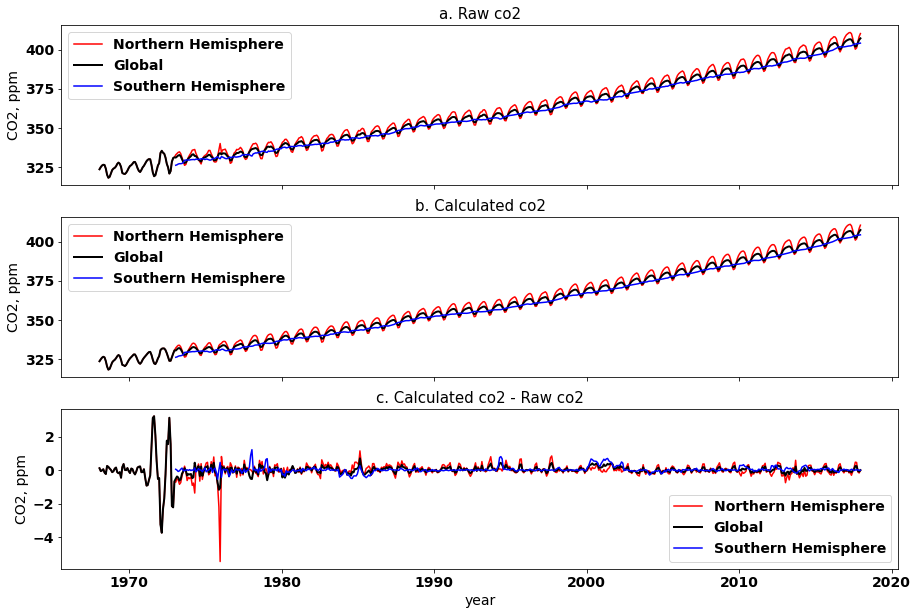

In [99]:
x_decimalyear = decimalDate_datetime(pd.to_datetime(pd.DataFrame(global_co2_raw.index)[0],format='%Y-%m-%d'))
fig,axis = plt.subplots(nrows=3,ncols=1,sharex=True, sharey=False, figsize = (15,10))
(ax1,ax2,ax3) = axis

ax1.plot(x_decimalyear,NH_co2_raw, 'r', label = "Northern Hemisphere")
ax1.plot(x_decimalyear,global_co2_raw, 'k', label = "Global", lw=2)
ax1.plot(x_decimalyear,SH_co2_raw,'b', label = "Southern Hemisphere")
ax1.set_ylabel("CO2, ppm")
ax1.legend()
ax1.set_title("a. Raw co2",fontsize=15)

ax2.plot(x_decimalyear,NH_co2_cal, 'r', label = "Northern Hemisphere")
ax2.plot(x_decimalyear,global_co2_cal, 'k', label = "Global", lw=2)
ax2.plot(x_decimalyear,SH_co2_cal,'b', label = "Southern Hemisphere")
ax2.set_ylabel("CO2, ppm")
ax2.legend()
ax2.set_title("b. Calculated co2",fontsize=15)

ax3.plot(x_decimalyear,NH_co2_cal - NH_co2_raw, 'r', label = "Northern Hemisphere")
ax3.plot(x_decimalyear,global_co2_cal - global_co2_raw, 'k', label = "Global", lw=2)
ax3.plot(x_decimalyear,SH_co2_cal - SH_co2_raw,'b', label = "Southern Hemisphere")
ax3.set_xlabel("year")
ax3.set_ylabel("CO2, ppm")
ax3.legend()
ax3.set_title("c. Calculated co2 - Raw co2",fontsize=15);

# Plot co2 zonal map 

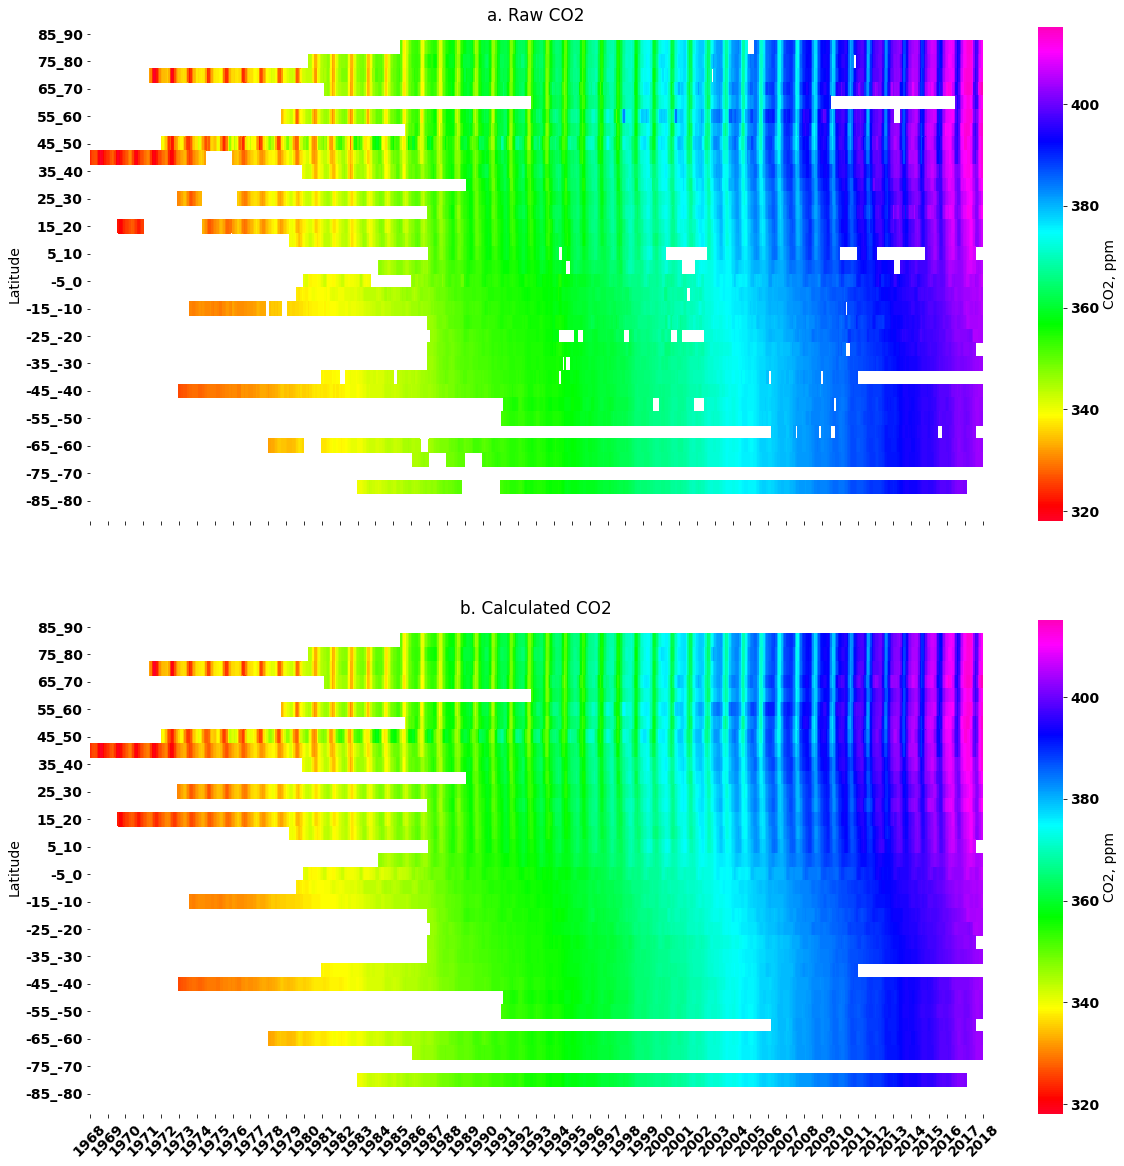

In [100]:
# Arrange dataframe for plot
df_co2_raw = pd.read_csv(IN_PATH + "df_co2_raw_wdcgg_obs_noaa.csv")
df_co2_cal = pd.read_csv(IN_PATH + "df_co2_cal_wdcgg_obs_noaa.csv")

zonal_deg = 5

lat_range = range(-90,90,zonal_deg)

df_zonal_raw = pd.DataFrame()
df_zonal_cal = pd.DataFrame() 
for i in lat_range:

    lat_id = (i < df_co2_raw.lat) & (df_co2_raw.lat<= i+zonal_deg)
    temp_raw = df_co2_raw.loc[lat_id,:]
    temp_cal = df_co2_cal.loc[lat_id,:]
    
    df_zonal_raw = pd.concat([df_zonal_raw,  pd.DataFrame(temp_raw.iloc[:,4:].mean()).T] )
    df_zonal_cal = pd.concat([df_zonal_cal,  pd.DataFrame(temp_cal.iloc[:,4:].mean()).T] )

df_zonal_raw["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
df_zonal_cal["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_raw.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_raw = df_zonal_raw.loc[:,cols_new]
df_zonal_cal = df_zonal_cal.loc[:,cols_new]
df_zonal_raw = df_zonal_raw.iloc[::-1] 
df_zonal_cal = df_zonal_cal.iloc[::-1] 
df_zonal_raw = df_zonal_raw.set_index(["lat"])
df_zonal_cal = df_zonal_cal.set_index(["lat"])

# plot
xticks = [i for i in range(0, df_zonal_raw.shape[1]+12, 12)]
xticklabels = [i for i in range(1968,2019)]

cmax = max(df_zonal_cal.max().max(), df_zonal_raw.max().max())
cmin = max(df_zonal_cal.min().min(), df_zonal_raw.min().min())

# sns.set(font_scale=1.4)

fig,axis = plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True,figsize=[20,20])
(ax1,ax2) = axis
sns.heatmap(df_zonal_raw, cmap=plt.get_cmap("gist_rainbow"), ax=ax1, cbar_kws={'label': 'CO2, ppm'}, vmax=cmax,vmin=cmin)
ax1.set_ylabel("Latitude")
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticklabels,rotation=45)
ax1.set_title("a. Raw CO2")

sns.heatmap(df_zonal_cal, cmap=plt.get_cmap("gist_rainbow"), ax=ax2, cbar_kws={'label': 'CO2, ppm'}, vmax=cmax,vmin=cmin)
ax2.set_ylabel("Latitude")
ax2.set_xticks(xticks) 
ax2.set_xticklabels(xticklabels,rotation=45)
ax2.set_title("b. Calculated CO2");

# Calculate zonal and global CO2 growth rate average over each 30 degree latitudinal band

In [102]:
df_co2rate_cal = pd.read_csv(IN_PATH + "df_co2rate_cal_wdcgg_obs_noaa.csv")

zonal_deg = 30

df_zonal_cal = zonal_mean(df_co2rate_cal, zonal_deg, df_co2rate_cal.columns[4:], "lat")

nanindex_cal  = df_zonal_cal.apply(np.isnan)

# area weight
df_area = pd.DataFrame(grid_area(0.5))
area_lat = df_area.iloc[:,0]
area_zonal = area_lat.groupby(np.arange(len(area_lat))//(zonal_deg/0.5)).sum()

global_weight = area_zonal/area_zonal.sum()
NH_weight = area_zonal[:len(area_zonal)/2-1] /(area_zonal.sum()/2)
SH_weight = area_zonal[len(area_zonal)/2:] /(area_zonal.sum()/2)

global_weight = global_weight.set_axis(df_zonal_cal.index)
NH_weight = NH_weight.set_axis(df_zonal_cal.index[:3])
SH_weight = SH_weight.set_axis(df_zonal_cal.index[3:])

# replicate weight column wise
df_global_weight= pd.concat([global_weight]*df_zonal_cal.shape[1], ignore_index=True, axis=1)
df_NH_weight= pd.concat([NH_weight]*df_zonal_cal.shape[1], ignore_index=True, axis=1)
df_SH_weight= pd.concat([SH_weight]*df_zonal_cal.shape[1], ignore_index=True, axis=1)
df_global_weight.columns = df_zonal_cal.columns
df_NH_weight.columns = df_zonal_cal.columns
df_SH_weight.columns = df_zonal_cal.columns

# recalculate weight due to some NAN
df_global_weight_cal = df_global_weight[~nanindex_cal].div(df_global_weight[~nanindex_cal].sum(), axis = 1) 
df_NH_weight_cal = df_NH_weight[~nanindex_cal].div(df_NH_weight[~nanindex_cal].sum(), axis = 1) 
df_SH_weight_cal = df_SH_weight[~nanindex_cal].div(df_SH_weight[~nanindex_cal].sum(), axis = 1)

# calculated global weighted average
global_co2rate_cal = df_zonal_cal.mul(df_global_weight_cal, axis = 1).sum(min_count=1)
NH_co2rate_cal = df_zonal_cal.iloc[:3,:].mul(df_NH_weight_cal, axis = 1).sum(min_count=1)
SH_co2rate_cal = df_zonal_cal.iloc[3:,:].mul(df_SH_weight_cal, axis = 1).sum(min_count=1)

# calculate annual co2
datetime = pd.to_datetime(pd.DataFrame(global_co2rate_cal.index)[0],format='%Y-%m-%d')
co2rate_annual = pd.concat([global_co2rate_cal,NH_co2rate_cal,SH_co2rate_cal],axis=1)
co2rate_annual.columns = ["global_co2rate_cal","NH_co2rate_cal","SH_co2rate_cal"]
co2rate_annual["year"] = datetime.dt.year.tolist()
co2rate_annual.groupby(["year"]).mean().T

year,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
global_co2rate_cal,0.902269,1.276174,1.435352,0.52276,1.187527,1.694323,0.337126,0.938756,0.785021,2.182173,...,1.696977,1.728989,2.319686,1.740972,2.717159,2.318120,1.853354,3.029266,2.921629,1.980547
NH_co2rate_cal,0.902269,1.276174,1.435352,0.52276,1.187527,1.796524,0.321185,1.062646,0.605279,2.340023,...,1.693174,1.814835,2.604561,1.632180,2.944410,2.202722,1.704114,3.105993,3.141880,1.893618
SH_co2rate_cal,NaN,NaN,NaN,NaN,NaN,1.490974,0.355532,0.795701,0.992569,1.999903,...,1.700780,1.643144,2.034811,1.849764,2.489908,2.433517,2.002594,2.952538,2.701378,2.067477


# Plot global, NH and SH area-weighted average CO2 growth rate

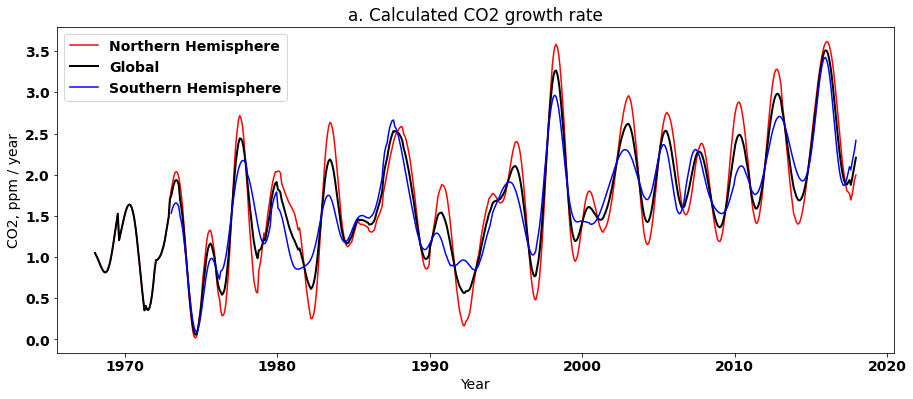

In [103]:
x_decimalyear = decimalDate_datetime(pd.to_datetime(pd.DataFrame(global_co2rate_cal.index)[0],format='%Y-%m-%d'))

fig = plt.figure( figsize = (15,6))
ax = plt.axes()

ax.plot(x_decimalyear,NH_co2rate_cal, 'r', label = "Northern Hemisphere")
ax.plot(x_decimalyear,global_co2rate_cal, 'k', label = "Global", lw=2)
ax.plot(x_decimalyear,SH_co2rate_cal,'b', label = "Southern Hemisphere")
ax.set_xlabel("Year")
ax.set_ylabel("CO2, ppm / year")
ax.legend()
ax.set_title("a. Calculated CO2 growth rate");


# Plot CO2 growth rate  zonal map

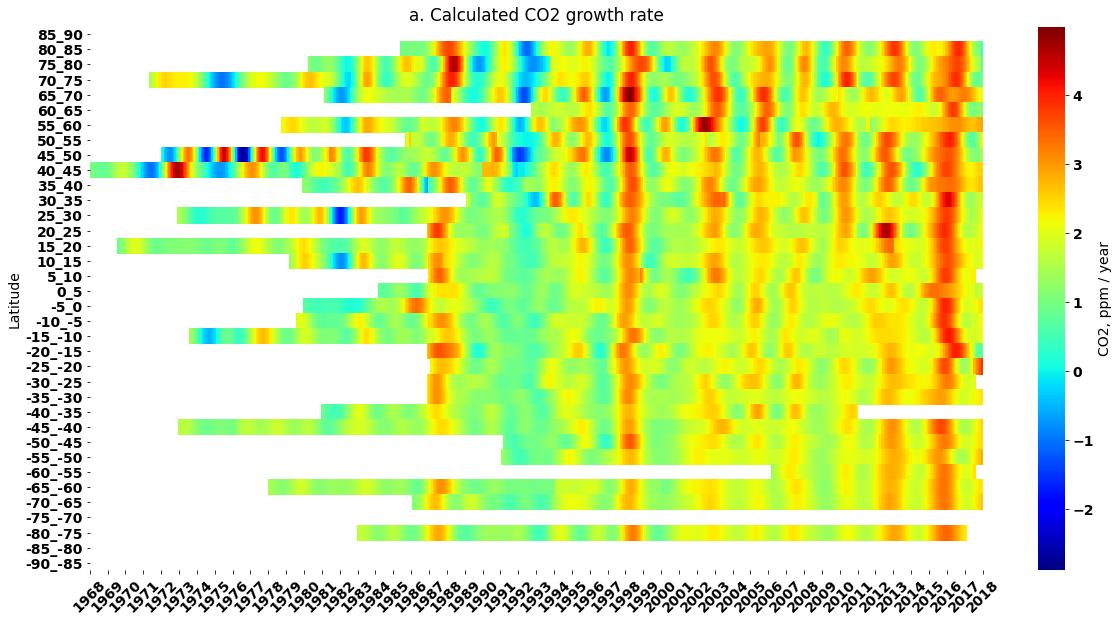

In [104]:
# Arrange dataframe for plot
df_co2_cal = pd.read_csv(IN_PATH + "df_co2rate_cal_wdcgg_obs_noaa.csv")

zonal_deg = 5
lat_range = range(-90,90,zonal_deg)
df_zonal_cal = pd.DataFrame() 

for i in lat_range:
    lat_id = (i < df_co2_raw.lat) & (df_co2_raw.lat<= i+zonal_deg)
    temp_cal = df_co2_cal.loc[lat_id,:]
    df_zonal_cal = pd.concat([df_zonal_cal,  pd.DataFrame(temp_cal.iloc[:,4:].mean()).T] )

df_zonal_cal["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
cols_new = df_zonal_cal.columns.to_list()
cols_new = cols_new[-1:] + cols_new[:-1]
df_zonal_cal = df_zonal_cal.loc[:,cols_new]
df_zonal_cal = df_zonal_cal.iloc[::-1] 
df_zonal_cal = df_zonal_cal.set_index(["lat"])

# plot
xticks = [i for i in range(0, df_zonal_cal.shape[1]+12, 12)]
xticklabels = [i for i in range(1968,2019)]

# sns.set(font_scale=1.4)
fig = plt.figure(figsize=[20,10])
# ax1 = plt.axis()
g = sns.heatmap(df_zonal_cal, cmap=plt.get_cmap("jet"), cbar_kws={'label': 'CO2, ppm / year'})
g.set_ylabel("Latitude")
g.set_xticks(xticks)
g.set_xticklabels(xticklabels,rotation=45) 
g.set_title("a. Calculated CO2 growth rate");


#BIR statation at (8.3, 58)